In [2]:
import re
import os
import cv2
import time
import random
import plotly.express as px
from tqdm import tqdm
from scipy import signal
import scipy as sp
import scipy.ndimage
import numpy as np
import typing as t
from PIL import Image
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras as k
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import roc_auc_score
from tensorflow.keras.models import load_model, Model
from joblib import Parallel, delayed
from skimage.transform import resize
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from catboost import CatBoostRegressor, CatBoostClassifier

import config as c
from utils.image_processing import crop_image
import utils.model as model_factory
from utils.dataset import get_train_data, get_test_data

plt.rcParams["figure.figsize"] = (10, 10)

In [3]:
def create_circular_mask(h, w, center=None, radius=None):
    if center is None:
        center = (int(w/2), int(h/2))
    if radius is None:
        radius = min(center[0], center[1], w-center[0], h-center[1])

    Y, X = np.ogrid[:h, :w]
    dist_from_center = np.sqrt((X - center[0])**2 + (Y-center[1])**2)

    mask = dist_from_center <= radius
    return mask

def get_height_map(img):
    m = np.zeros((30))
    for r in range(0, 30, 2):
        mask = create_circular_mask(80, 80, radius=r) * (~create_circular_mask(80, 80, radius=r-1))
        m[r] = np.sum(mask * img) / np.sum(mask)
    m -= m.min()
    m /= m.max()
    return m

def get_height_map(img):
    m = np.zeros((30))
    for r in range(0, 30, 2):
        mask = create_circular_mask(80, 80, radius=r) * (~create_circular_mask(80, 80, radius=r-2))
        if np.sum(mask) > 3:
            mask = (mask * img < np.quantile(img[mask], 0.95)) & mask
            mask = (mask * img > np.quantile(img[mask], 0.02)) & mask
        m[r] = np.sum(mask * img) / np.sum(mask)
    m -= m.min()
    m /= m.max()
    return m

def get_histogram_map(img, radius_0=7, radius_1=30):
    mask = create_circular_mask(80, 80, radius=radius_1) * (~create_circular_mask(80, 80, radius=radius_0))
    m = np.histogram(img[mask], range=(100, 120), bins=20)[0]
    
    return m

def get_img_spector(img):
    sum_img = np.sum(img*create_circular_mask(80, 80, radius=20)).reshape(-1)
    std_img = np.std(img*create_circular_mask(80, 80, radius=20)).reshape(-1)
    
    histogram_map_0_7 = get_histogram_map(img, 0, 6)
    histogram_map_7_30 = get_histogram_map(img, 6, 30)
    img = sp.ndimage.filters.gaussian_filter(img, [5.0, 5.0])
    
    height_map = get_height_map(img)
    spector = np.concatenate([histogram_map_0_7, histogram_map_7_30, height_map, sum_img, std_img])
    return spector

def get_circular_ratio(img):
    img_gaussian = sp.ndimage.filters.gaussian_filter(img.copy(), [3.0, 3.0])
    gaussian_mask = img_gaussian > np.quantile(img_gaussian, 0.995)
    r = np.sqrt(np.sum(gaussian_mask)/np.pi)
    mask = create_circular_mask(250, 250, radius=r)
    return np.sum(mask*gaussian_mask)/np.sum(mask+gaussian_mask)

def get_bright_sum(img):
    img_gaussian = sp.ndimage.filters.gaussian_filter(img.copy(), [3.0, 3.0])
    gaussian_mask = img_gaussian > np.quantile(img_gaussian, 0.98)#112
    return np.sum(img[gaussian_mask]-100.4)/1000

In [15]:
df = get_train_data(available_energy_values=[1, 3, 6, 10, 20, 30], input_shape=(250, 250), values_linear_transformation=False, center_by_max=False, short_load=False, distance_matrices=False, return_as_dataframe=True)
df['circular_ratio'] = np.array(Parallel(n_jobs=c.NUM_CORES)(delayed(get_circular_ratio)(img) for img in tqdm(df['img_250'])))
df['bright_sum'] = np.array(Parallel(n_jobs=c.NUM_CORES)(delayed(get_bright_sum)(img) for img in tqdm(df['img_250'])))

100%|██████████| 13404/13404 [00:10<00:00, 1282.84it/s]


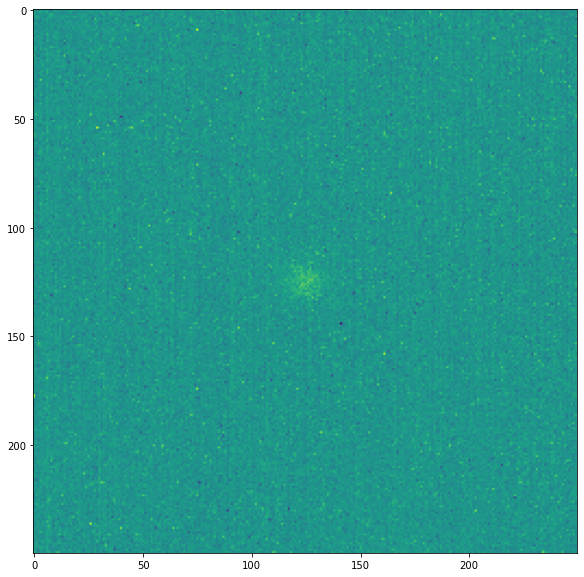

In [16]:
plt.imshow(df['img_250'][0])

In [137]:
def best_fit_distribution(data, bins=50, hist_range=(90, 140), ax=None):
    """Model data by finding best fit distribution to data"""
    # Get histogram of original data
    y, x = np.histogram(data, bins=bins, density=True, range=hist_range)
    x = (x + np.roll(x, -1))[:-1] / 2.0

    # Distributions to check
    DISTRIBUTIONS = [        
        st.lognorm
    ]

    # Best holders
    best_distribution = st.norm
    best_params = (0.0, 1.0)
    best_sse = np.inf

    # Estimate distribution parameters from data
    for distribution in DISTRIBUTIONS:

        # Try to fit the distribution
        try:
            # Ignore warnings from data that can't be fit
            with warnings.catch_warnings():
                warnings.filterwarnings('ignore')

                # fit dist to data
                params = distribution.fit(data)

                # Separate parts of parameters
                arg = params[:-2]
                loc = params[-2]
                scale = params[-1]

                # Calculate fitted PDF and error with fit in distribution
                pdf = distribution.pdf(x, loc=loc, scale=scale, *arg)
                sse = np.sum(np.power(y - pdf, 2.0))

                # if axis pass in add to plot
                try:
                    if ax:
                        pd.Series(pdf, x).plot(ax=ax)
                    end
                except Exception:
                    pass

                # identify if this distribution is better
                if best_sse > sse > 0:
                    best_distribution = distribution
                    best_params = params
                    best_sse = sse

        except Exception:
            pass

    return (best_distribution.name, best_params)

def make_pdf(dist, params, size=10000):
    """Generate distributions's Probability Distribution Function """

    # Separate parts of parameters
    arg = params[:-2]
    loc = params[-2]
    scale = params[-1]

    # Get sane start and end points of distribution
    start = dist.ppf(0.01, *arg, loc=loc, scale=scale) if arg else dist.ppf(0.01, loc=loc, scale=scale)
    end = dist.ppf(0.99, *arg, loc=loc, scale=scale) if arg else dist.ppf(0.99, loc=loc, scale=scale)

    # Build PDF and turn into pandas Series
    x = np.linspace(start, end, size)
    y = dist.pdf(x, loc=loc, scale=scale, *arg)
    pdf = pd.Series(y, x)

    return pdf

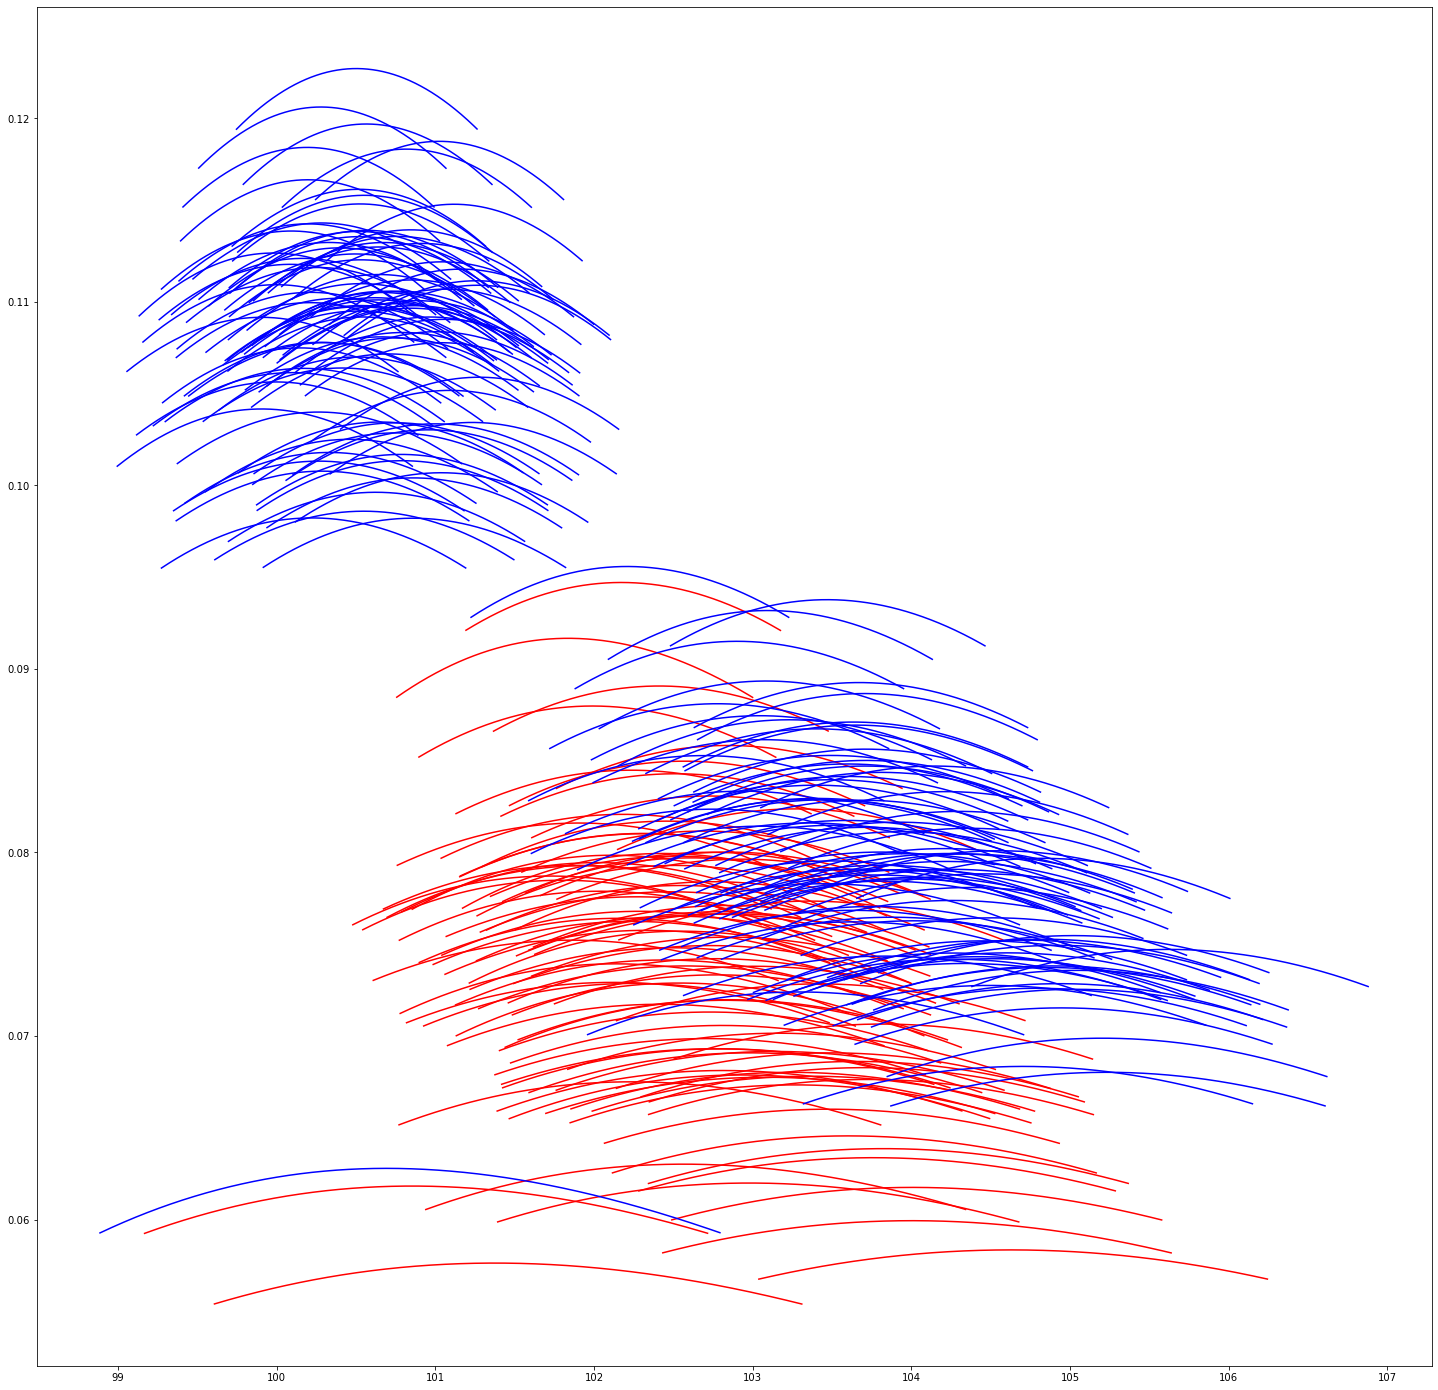

In [191]:
mask = create_circular_mask(250, 250, radius=13)

plt.rcParams["figure.figsize"] = (25, 25)
for i in range(100):
    img = df[(df.e==3)&(df.t==0)]['img_250'].iloc[i]
    best_fit_name, best_fit_params = best_fit_distribution(img[mask])
    best_dist = getattr(st, best_fit_name)
    
    pdf = make_pdf(best_dist, best_fit_params)
    if best_fit_params[0]<1:
        plt.plot(pdf[pdf>np.quantile(pdf, 0.9)], color='r')
    #print(best_fit_params)
    

for i in range(100):
    img = df[(df.e==1)&(df.t==1)]['img_250'].iloc[i]
    best_fit_name, best_fit_params = best_fit_distribution(img[mask])
    best_dist = getattr(st, best_fit_name)
    if best_fit_params[0]<1:
        pdf = make_pdf(best_dist, best_fit_params)
        plt.plot(pdf[pdf>np.quantile(pdf, 0.9)], color='b')
        #print(best_fit_params)
        

for i in range(100):
    img = df[(df.e==6)&(df.t==1)]['img_250'].iloc[i]
    best_fit_name, best_fit_params = best_fit_distribution(img[mask])
    best_dist = getattr(st, best_fit_name)
    if best_fit_params[0]<1:
        pdf = make_pdf(best_dist, best_fit_params)
        plt.plot(pdf[pdf>np.quantile(pdf, 0.9)], color='b')

In [183]:
np.argmax(pdf)

4228

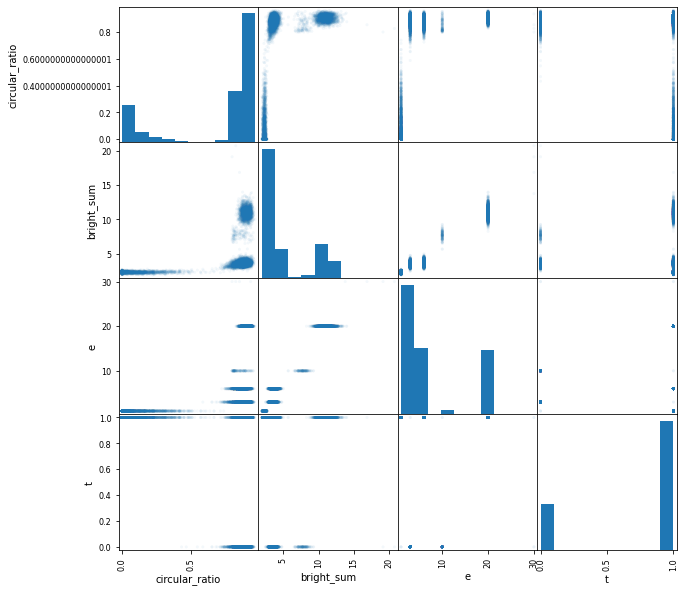

In [175]:
from pandas.plotting import scatter_matrix
scatter_matrix(df[['circular_ratio', 'bright_sum', 'e', 't']], alpha=0.05, figsize=(10, 10));

In [125]:
np.sum((df.circular_ratio<0.8)&(df.t==0)&(df.bright_sum>7))

4095

In [126]:
np.sum((df.circular_ratio<0.8)&(df.t==1)&(df.bright_sum>7))

0

In [127]:
df_center_shifted = df[((df.circular_ratio<0.8)&(df.bright_sum>5))]
df = df[~((df.circular_ratio<0.8)&(df.bright_sum>5))]

In [309]:
df['img_80'] = Parallel(n_jobs=c.NUM_CORES)(delayed(crop_image)(img, (80, 80), False) for img in tqdm(df['img_250']))
df['img_80'] = df['img_80'].map(lambda img: img-np.mean((img[:25]+img[-25:]), axis=0).reshape(1, 80)/2+100.4)
df['spector'] = Parallel(n_jobs=c.NUM_CORES)(delayed(get_img_spector)(img) for img in tqdm(df['img_80']))

100%|██████████| 9028/9028 [00:22<00:00, 396.25it/s]


In [310]:
df_center_shifted.head()

,t,e,img_250,circular_ratio,bright_sum
6646,0,30,"[[100.0, 98.0, 97.0, 99.0, 100.0, 100.0, 100.0...",0.000000,19.178000
6649,0,10,"[[100.0, 97.0, 101.0, 101.0, 101.0, 93.0, 99.0...",0.770774,7.137998
6653,0,10,"[[100.0, 102.0, 107.0, 101.0, 96.0, 98.0, 103....",0.661290,7.563998
6654,0,10,"[[102.0, 102.0, 101.0, 101.0, 101.0, 98.0, 99....",0.796512,7.521998
6655,0,30,"[[105.0, 98.0, 101.0, 99.0, 105.0, 97.0, 100.0...",0.000000,20.257000


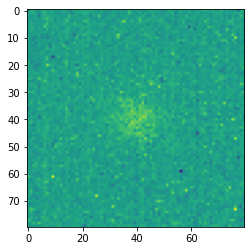

In [311]:
plt.imshow(df['img_80'].iloc[0])

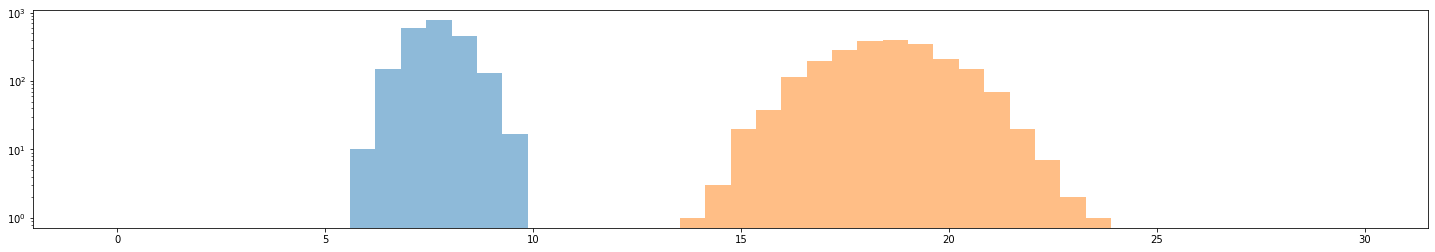

In [312]:
plt.rcParams["figure.figsize"] = (25, 4)
plt.hist(df_center_shifted.bright_sum[df_center_shifted.e==10], bins=50, alpha=0.5, range=(-0.5, 30), log=True)
#plt.hist(df_center_shifted.bright_sum[df_center_shifted.e==20], bins=200, alpha=0.5, range=(-0.5, 30), log=True)
plt.hist(df_center_shifted.bright_sum[df_center_shifted.e==30], bins=50, alpha=0.5, range=(-0.5, 30), log=True)
plt.show()

In [313]:
df.head()

,t,e,img_250,circular_ratio,bright_sum,img_80,spector,predict,particle_types_predict
0,1,6,"[[105.0, 100.0, 96.0, 103.0, 99.0, 103.0, 103....",0.884146,3.486998,"[[93.0, 105.0, 104.0, 98.0, 98.0, 104.0, 104.0...","[1, 3, 3, 3, 4, 2, 9, 13, 5, 9, 11, 12, 9, 11,...",0.895534,1
1,1,20,"[[106.0, 97.0, 98.0, 101.0, 101.0, 101.0, 104....",0.925234,10.607998,"[[102.0, 101.0, 101.0, 98.0, 100.0, 102.0, 100...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...",1.188698,1
2,1,20,"[[104.0, 101.0, 98.0, 99.0, 103.0, 105.0, 101....",0.913313,9.111998,"[[101.0, 100.0, 102.0, 101.0, 100.0, 102.0, 10...","[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, ...",0.971342,1
3,1,20,"[[95.0, 104.0, 101.0, 99.0, 103.0, 100.0, 98.0...",0.919255,10.104999,"[[97.0, 100.0, 96.0, 98.0, 100.0, 99.0, 103.0,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1.021732,1
4,1,20,"[[95.0, 100.0, 94.0, 98.0, 98.0, 99.0, 95.0, 1...",0.878419,12.223998,"[[99.0, 107.0, 99.0, 101.0, 103.0, 100.0, 101....","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...",0.920865,1


In [314]:
x = np.concatenate([df['spector'].to_numpy().tolist(), df[['bright_sum', 'circular_ratio']].to_numpy().tolist()], axis=1)
x = np.concatenate([df['spector'].to_numpy().tolist()], axis=1)
y = df.t.to_numpy().reshape(-1, 1)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.4, random_state=42)

In [316]:
particle_types_model = CatBoostClassifier(iterations=100,
                          learning_rate=3e-2,
                          l2_leaf_reg=3.0,  # any pos value
                          depth=5,  # int up to 16
                          min_data_in_leaf=1,  # 1,2,3,4,5
                          rsm=1,  # 0.01 .. 1.0
                          langevin=False,
                          task_type="GPU",
                          devices='0:1')

particle_types_model.fit(x_train, y_train, eval_set=(x_test, y_test), verbose=0)
print(roc_auc_score(particle_types_model.predict(x_train), y_train), roc_auc_score(particle_types_model.predict(x_test), y_test))

0.9723191342011538 0.9524877301476473


In [317]:
particle_types_model = CatBoostRegressor(iterations=100,
                          learning_rate=3e-2,
                          l2_leaf_reg=3.0,  # any pos value
                          depth=5,  # int up to 16
                          min_data_in_leaf=1,  # 1,2,3,4,5
                          rsm=1,  # 0.01 .. 1.0
                          langevin=False,
                          task_type="GPU",
                          devices='0:1')

particle_types_model.fit(x_train, y_train, eval_set=(x_test, y_test), verbose=0)
print(roc_auc_score(particle_types_model.predict(x_train)>0.5, y_train), roc_auc_score(particle_types_model.predict(x_test)>0.5, y_test))

0.9614834992640844 0.9376086924256826


In [318]:
particle_types_model = LinearRegression().fit(x_train, y_train)
particle_types_model.score(x_train, y_train)


print(roc_auc_score(particle_types_model.predict(x_train)>0.5, y_train), roc_auc_score(particle_types_model.predict(x_test)>0.5, y_test))

0.9764173917234793 0.9749755609354881


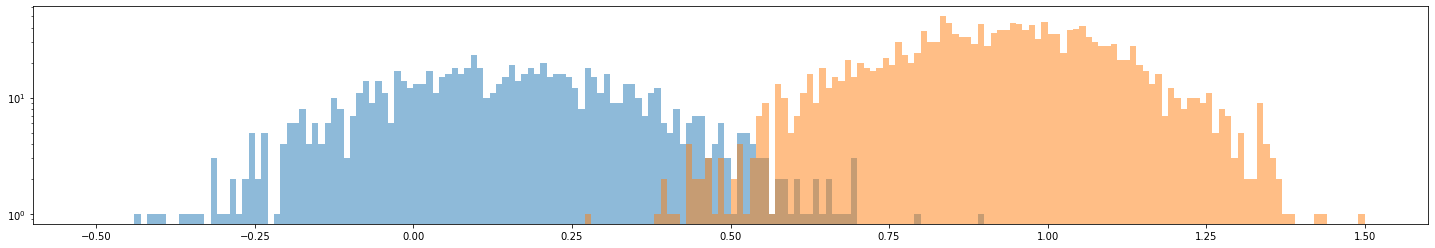

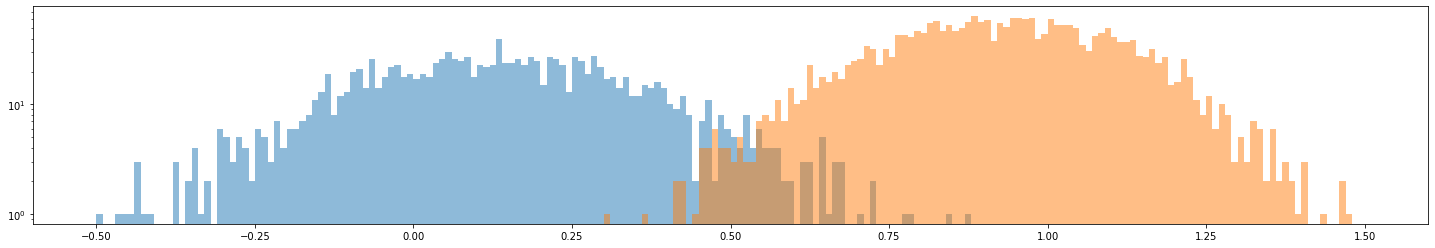

In [319]:
plt.rcParams["figure.figsize"] = (25, 4)
plt.hist(particle_types_model.predict(x_test[y_test.reshape(-1)==0]), bins=200, alpha=0.5, range=(-0.5, 1.5), log=True)
plt.hist(particle_types_model.predict(x_test[y_test.reshape(-1)==1]), bins=200, alpha=0.5, range=(-0.5, 1.5), log=True)
plt.show()

plt.hist(particle_types_model.predict(x_train[y_train.reshape(-1)==0]), bins=200, alpha=0.5, range=(-0.5, 1.5), log=True)
plt.hist(particle_types_model.predict(x_train[y_train.reshape(-1)==1]), bins=200, alpha=0.5, range=(-0.5, 1.5), log=True)
plt.show()

In [243]:
bad_df = df[(df['predict']>0.3)&(df['predict']<0.7)]

In [244]:
df['predict'] = particle_types_model.predict(x)
df['particle_types_predict'] = (particle_types_model.predict(x)>0.5)*1

In [275]:
df[df.t!=df.particle_types_predict]#.head()

,t,e,img_250,circular_ratio,bright_sum,img_80,spector,predict,particle_types_predict
5668,1,6,"[[100.0, 100.0, 100.0, 101.0, 97.0, 98.0, 114....",0.889908,3.106998,"[[105.8, 96.3, 99.98, 103.54, 103.94, 98.64, 1...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.482774,0
6816,0,3,"[[97.0, 101.0, 100.0, 100.0, 101.0, 101.0, 98....",0.828402,2.988998,"[[100.68, 98.26, 100.32, 107.94, 105.74, 99.68...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.533588,1
8251,0,30,"[[104.0, 103.0, 98.0, 101.0, 102.0, 99.0, 100....",0.801749,19.115000,"[[97.96, 103.28, 104.72, 98.6, 109.86, 103.26,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1.055406,1
9888,0,3,"[[101.0, 101.0, 99.0, 99.0, 103.0, 101.0, 99.0...",0.872727,3.427998,"[[102.46, 94.380005, 102.74, 104.48, 98.520004...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.526715,1
10194,0,3,"[[95.0, 101.0, 102.0, 99.0, 99.0, 103.0, 99.0,...",0.817647,3.235998,"[[95.86, 94.58, 102.4, 104.82, 96.060005, 100....","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.530154,1
10444,0,3,"[[90.0, 99.0, 103.0, 98.0, 106.0, 93.0, 105.0,...",0.812317,2.585998,"[[102.62, 100.94, 101.08, 100.020004, 104.46, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.507393,1
10978,0,3,"[[103.0, 101.0, 103.0, 102.0, 95.0, 103.0, 104...",0.861446,3.497998,"[[97.26, 102.78, 101.78, 99.98, 100.54, 95.24,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.513329,1
11077,0,1,"[[103.0, 99.0, 99.0, 98.0, 96.0, 102.0, 102.0,...",0.548872,2.636998,"[[103.14, 107.28, 97.72, 104.16, 108.36, 99.5,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.593034,1
11269,0,1,"[[95.0, 100.0, 100.0, 98.0, 99.0, 102.0, 95.0,...",0.433875,2.663998,"[[102.6, 95.8, 100.18, 104.700005, 100.26, 102...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.506079,1
12858,0,30,"[[104.0, 100.0, 91.0, 100.0, 97.0, 100.0, 95.0...",0.828402,20.727000,"[[99.22, 99.880005, 100.200005, 100.96, 99.560...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1.264615,1


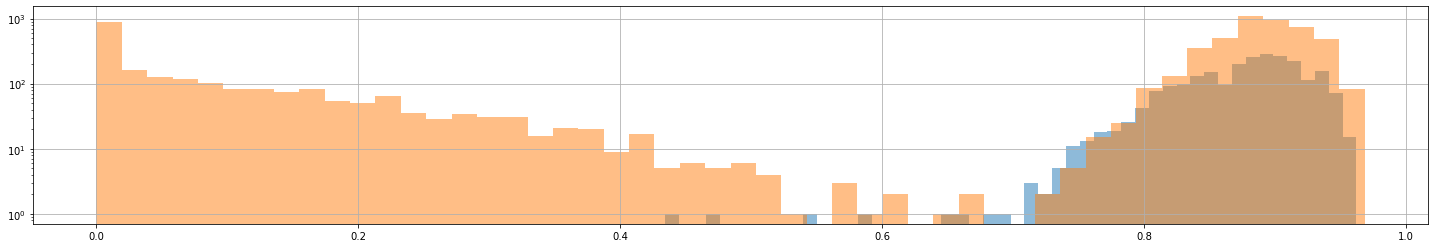

In [247]:
plt.hist(df[df.t==0].circular_ratio, bins=50, alpha=0.5, log=True)
plt.hist(df[df.t==1].circular_ratio, bins=50, alpha=0.5, log=True)
plt.grid()
plt.show()

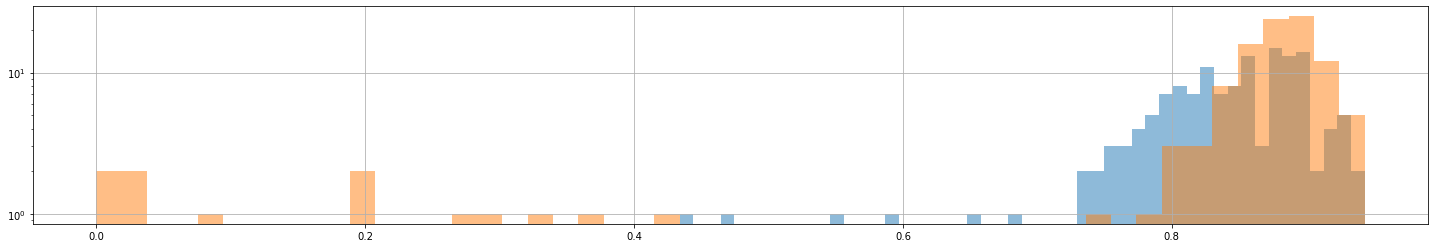

In [248]:
plt.hist(bad_df[bad_df.t==0].circular_ratio, bins=50, alpha=0.5, log=True)
plt.hist(bad_df[bad_df.t==1].circular_ratio, bins=50, alpha=0.5, log=True)
plt.grid()
plt.show()

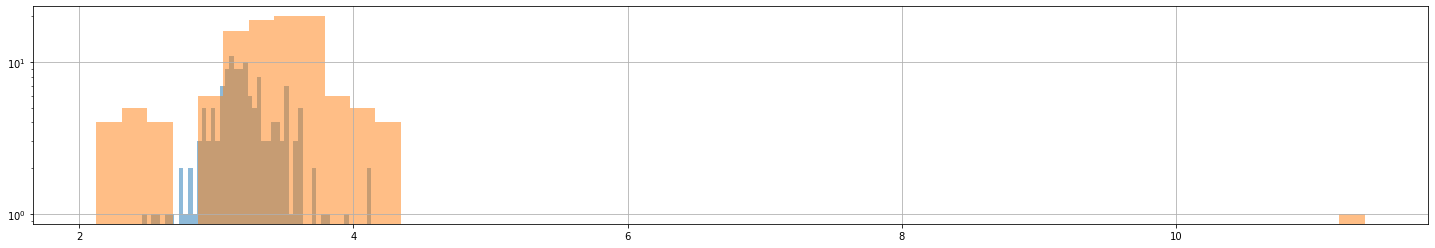

In [249]:
plt.hist(bad_df[bad_df.t==0].bright_sum, bins=50, alpha=0.5, log=True)
plt.hist(bad_df[bad_df.t==1].bright_sum, bins=50, alpha=0.5, log=True)
plt.grid()
plt.show()

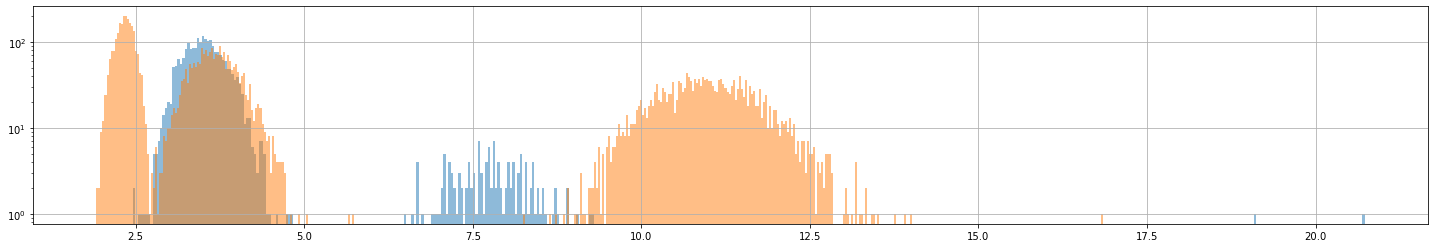

In [276]:
plt.hist(df[df.t==0].bright_sum, bins=500, alpha=0.5, log=True)
plt.hist(df[df.t==1].bright_sum, bins=500, alpha=0.5, log=True)
plt.grid()
plt.show()

0:	learn: 0.4821180	test: 0.4830340	best: 0.4830340 (0)	total: 4.85ms	remaining: 165ms
1:	learn: 0.4695100	test: 0.4713484	best: 0.4713484 (1)	total: 8.86ms	remaining: 146ms
2:	learn: 0.4572574	test: 0.4601240	best: 0.4601240 (2)	total: 13ms	remaining: 138ms
3:	learn: 0.4453697	test: 0.4491839	best: 0.4491839 (3)	total: 17ms	remaining: 132ms
4:	learn: 0.4334338	test: 0.4382766	best: 0.4382766 (4)	total: 20.9ms	remaining: 125ms
5:	learn: 0.4221728	test: 0.4281163	best: 0.4281163 (5)	total: 25.1ms	remaining: 121ms
6:	learn: 0.4109983	test: 0.4180585	best: 0.4180585 (6)	total: 29.1ms	remaining: 116ms
7:	learn: 0.3998288	test: 0.4080634	best: 0.4080634 (7)	total: 33.1ms	remaining: 112ms
8:	learn: 0.3898790	test: 0.3993895	best: 0.3993895 (8)	total: 37.1ms	remaining: 107ms
9:	learn: 0.3798739	test: 0.3905627	best: 0.3905627 (9)	total: 41.3ms	remaining: 103ms
10:	learn: 0.3702378	test: 0.3819315	best: 0.3819315 (10)	total: 45.2ms	remaining: 98.7ms
11:	learn: 0.3609757	test: 0.3737249	best: 0

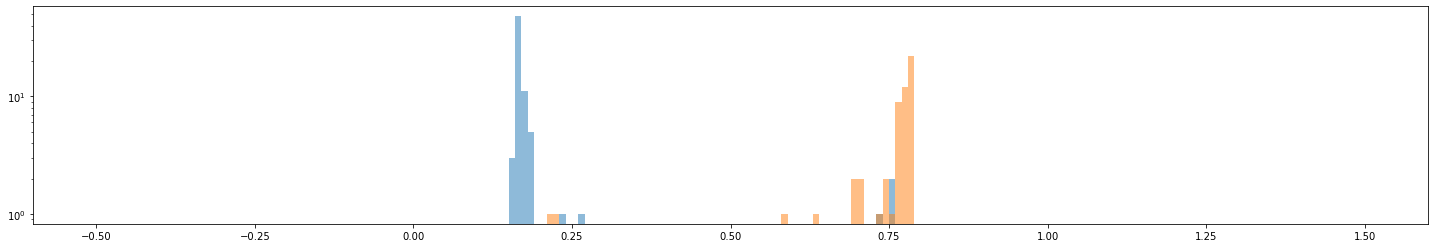

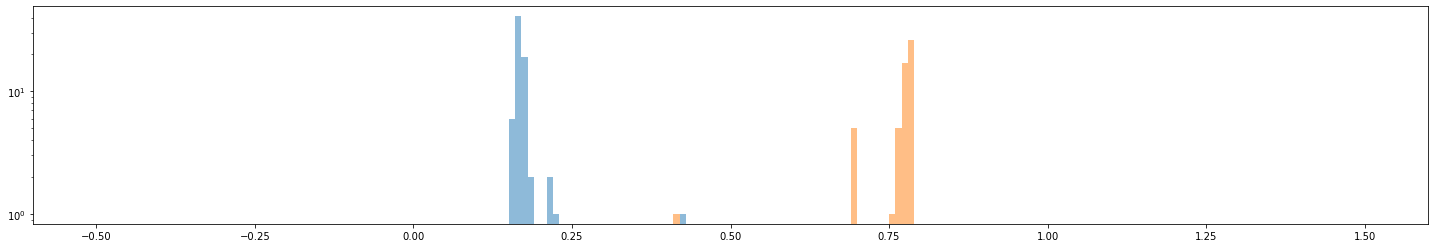

In [259]:
x = np.concatenate([bad_df[['bright_sum', 'circular_ratio', 'predict']].to_numpy().tolist()], axis=1)
y = bad_df.t.to_numpy().reshape(-1, 1)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.5, random_state=42)

particle_types_model = CatBoostRegressor(iterations=35,
                          learning_rate=3e-2,
                          l2_leaf_reg=3.0,  # any pos value
                          depth=5,  # int up to 16
                          min_data_in_leaf=1,  # 1,2,3,4,5
                          rsm=1,  # 0.01 .. 1.0
                          langevin=False,
                          task_type="GPU",
                          devices='0:1')

particle_types_model.fit(x_train, y_train, eval_set=(x_test, y_test), verbose=1)
print(roc_auc_score(particle_types_model.predict(x_train)>0.5, y_train), roc_auc_score(particle_types_model.predict(x_test)>0.5, y_test))

plt.rcParams["figure.figsize"] = (25, 4)
plt.hist(particle_types_model.predict(x_test[y_test.reshape(-1)==0]), bins=200, alpha=0.5, range=(-0.5, 1.5), log=True)
plt.hist(particle_types_model.predict(x_test[y_test.reshape(-1)==1]), bins=200, alpha=0.5, range=(-0.5, 1.5), log=True)
plt.show()

plt.hist(particle_types_model.predict(x_train[y_train.reshape(-1)==0]), bins=200, alpha=0.5, range=(-0.5, 1.5), log=True)
plt.hist(particle_types_model.predict(x_train[y_train.reshape(-1)==1]), bins=200, alpha=0.5, range=(-0.5, 1.5), log=True)
plt.show()

In [22]:
energies_model=None

In [23]:
df_t0 = df[df.t==0]
df_t0=df_t0[df_t0.e.isin([3, 10, 30])]

x = np.concatenate([df_t0['spector'].to_numpy().tolist(), df_t0[['bright_sum', 'circular_ratio']].to_numpy().tolist()], axis=1)
y = df_t0.e.to_numpy().reshape(-1, 1)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.4, random_state=42)

In [24]:
energies_model_t0 = CatBoostRegressor(iterations=100,
                          learning_rate=3e-2,
                          l2_leaf_reg=3.0,  # any pos value
                          depth=5,  # int up to 16
                          min_data_in_leaf=1,  # 1,2,3,4,5
                          rsm=1,  # 0.01 .. 1.0
                          langevin=False,
                          task_type="GPU",
                          devices='0:1')

energies_model_t0.fit(x_train, y_train, eval_set=(x_test, y_test), verbose=0)
print(mean_absolute_error(energies_model_t0.predict(x_train), y_train), mean_absolute_error(energies_model_t0.predict(x_test), y_test))

0.06796499490494397 0.05384196539530765


In [25]:
plt.rcParams["figure.figsize"] = (25, 4)
#plt.hist(energies_model_t0.predict(x[y.reshape(-1)==3]), bins=200, alpha=0.5, range=(-0.5, 35), log=True)
#plt.hist(energies_model_t0.predict(x[y.reshape(-1)==10]), bins=200, alpha=0.5, range=(-0.5, 35), log=True)
#plt.hist(energies_model_t0.predict(x[y.reshape(-1)==30]), bins=200, alpha=0.5, range=(-0.5, 35), log=True)
plt.show()

In [26]:
df_t0 = df[df.t==0]
df_t0=df_t0[df_t0.e.isin([1, 6, 20])]

x = np.concatenate([df_t0['spector'].to_numpy().tolist(), df_t0[['bright_sum', 'circular_ratio']].to_numpy().tolist()], axis=1)
y = df_t0.e.to_numpy().reshape(-1, 1)

plt.rcParams["figure.figsize"] = (25, 4)
#plt.hist(energies_model_t0.predict(x[y.reshape(-1)==1]), bins=200, alpha=0.5, range=(-0.5, 10))
#plt.hist(energies_model_t0.predict(x[y.reshape(-1)==6]), bins=200, alpha=0.5, range=(-0.5, 10))
plt.show()

In [27]:
df_t0 = df[df.t==1]
df_t0=df_t0[df_t0.e.isin([1, 6, 20])]

x = np.concatenate([df_t0['spector'].to_numpy().tolist(), df_t0[['bright_sum', 'circular_ratio']].to_numpy().tolist()], axis=1)
y = df_t0.e.to_numpy().reshape(-1, 1)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.4, random_state=42)

In [28]:
energies_model_t1 = CatBoostRegressor(iterations=100,
                          learning_rate=3e-2,
                          l2_leaf_reg=3.0,  # any pos value
                          depth=5,  # int up to 16
                          min_data_in_leaf=1,  # 1,2,3,4,5
                          rsm=1,  # 0.01 .. 1.0
                          langevin=False,
                          task_type="GPU",
                          devices='0:1')

energies_model_t1.fit(x_train, y_train, eval_set=(x_test, y_test), verbose=0)
print(mean_absolute_error(energies_model_t1.predict(x_train), y_train), mean_absolute_error(energies_model_t1.predict(x_test), y_test))

0.36034360087701844 0.3628055251515489


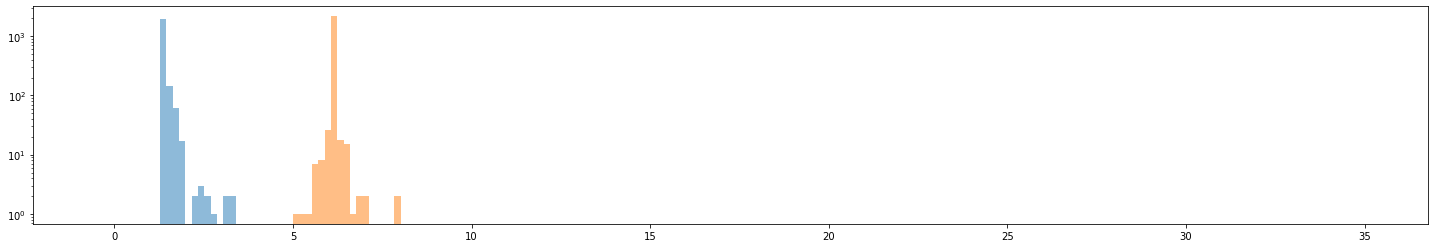

In [29]:
plt.rcParams["figure.figsize"] = (25, 4)
plt.hist(energies_model_t1.predict(x[y.reshape(-1)==1]), bins=200, alpha=0.5, range=(-0.5, 35), log=True)
plt.hist(energies_model_t1.predict(x[y.reshape(-1)==6]), bins=200, alpha=0.5, range=(-0.5, 35), log=True)
#plt.hist(energies_model.predict(x[y.reshape(-1)==30]), bins=200, alpha=0.5, range=(-0.5, 35), log=True)
plt.show()

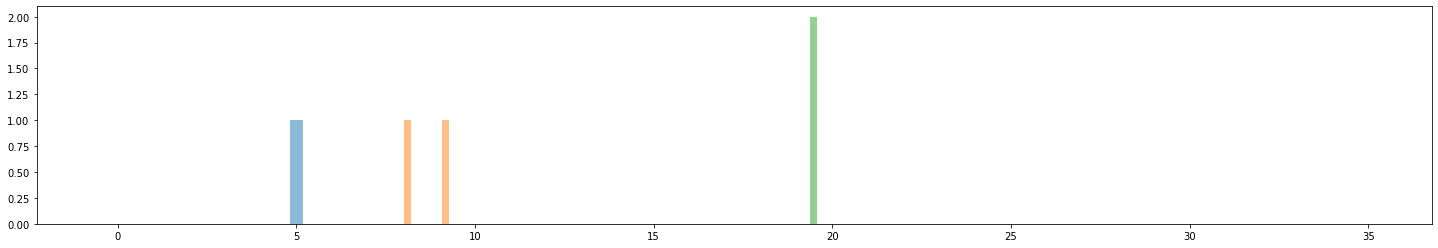

In [30]:
df_t0 = df[df.t==1]
df_t0=df_t0[df_t0.e.isin([3, 10, 30])]

x = np.concatenate([df_t0['spector'].to_numpy().tolist(), df_t0[['bright_sum', 'circular_ratio']].to_numpy().tolist()], axis=1)
y = df_t0.e.to_numpy().reshape(-1, 1)

plt.rcParams["figure.figsize"] = (25, 4)
plt.hist(energies_model_t1.predict(x[y.reshape(-1)==3]), bins=200, alpha=0.5, range=(-0.5, 35))
plt.hist(energies_model_t1.predict(x[y.reshape(-1)==10]), bins=200, alpha=0.5, range=(-0.5, 35))
plt.hist(energies_model_t1.predict(x[y.reshape(-1)==30]), bins=200, alpha=0.5, range=(-0.5, 35))
plt.show()

In [54]:
df_test = get_test_data(input_shape=(250, 250))
df_test['circular_ratio'] = np.array(Parallel(n_jobs=c.NUM_CORES)(delayed(get_circular_ratio)(img) for img in tqdm(df_test['img_250'])))
df_test['bright_sum'] = np.array(Parallel(n_jobs=c.NUM_CORES)(delayed(get_bright_sum)(img) for img in tqdm(df_test['img_250'])))

100%|██████████| 1502/1502 [00:00<00:00, 2189.51it/s]


In [55]:
df_test['id'] = df_test['file_names'].map(lambda file_name: file_name[:-4])

In [56]:
df_test.head()

,file_names,id,img_250,circular_ratio,bright_sum
0,001ec8f4d2679f2899a63e4b2597c0a10bd9393f.png,001ec8f4d2679f2899a63e4b2597c0a10bd9393f,"[[102.0, 103.0, 102.0, 103.0, 101.0, 102.0, 99...",0.895706,10.507998
1,00327390bfd6101b87106e96e0efc1c938690e1f.png,00327390bfd6101b87106e96e0efc1c938690e1f,"[[95.0, 100.0, 99.0, 104.0, 103.0, 101.0, 103....",0.796512,3.450998
2,00573dde8addbac780cfa35a55a790fa1aa45178.png,00573dde8addbac780cfa35a55a790fa1aa45178,"[[102.0, 94.0, 100.0, 102.0, 93.0, 102.0, 99.0...",0.889908,11.896999
3,00cb5b91a4acdfaa2f55dc2266e598ff06f9209e.png,00cb5b91a4acdfaa2f55dc2266e598ff06f9209e,"[[100.0, 100.0, 104.0, 101.0, 102.0, 99.0, 103...",0.823009,3.516998
4,00de1146bdcbfb02ed5f0e13fd6b9fe62157c0b2.png,00de1146bdcbfb02ed5f0e13fd6b9fe62157c0b2,"[[101.0, 101.0, 99.0, 103.0, 100.0, 105.0, 98....",0.861446,2.985998


In [57]:
np.sum((df_test.circular_ratio<0.8)&(df_test.bright_sum>5))

486

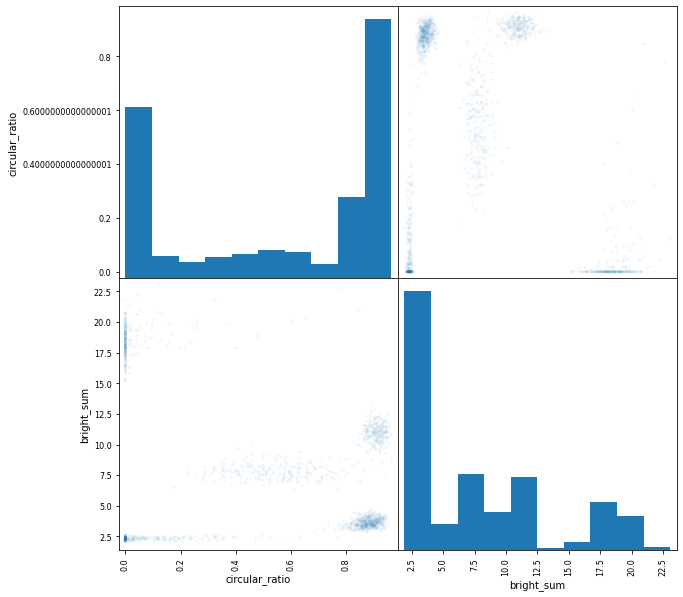

In [58]:
from pandas.plotting import scatter_matrix
scatter_matrix(df_test[['circular_ratio', 'bright_sum']], alpha=0.05, figsize=(10, 10));

In [90]:
df_test['is_center_shifted'] = ((df_test.circular_ratio<0.8)&(df_test.bright_sum>5))

df_test['img_80'] = Parallel(n_jobs=c.NUM_CORES)(delayed(crop_image)(img, (80, 80), False) for img in tqdm(df_test['img_250']))
df_test['img_80'] = df_test['img_80'].map(lambda img: img-np.mean((img[:25]+img[-25:]), axis=0).reshape(1, 80)/2+100.4)
df_test['spector'] = Parallel(n_jobs=c.NUM_CORES)(delayed(get_img_spector)(img) for img in tqdm(df_test['img_80']))

100%|██████████| 1502/1502 [00:03<00:00, 397.67it/s]


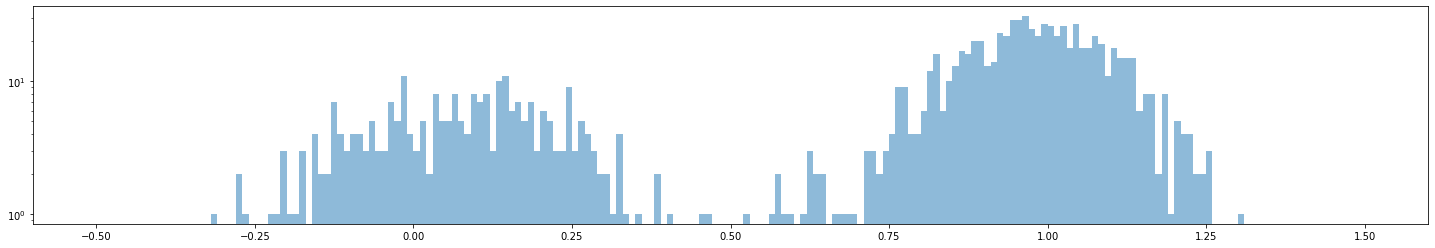

In [91]:
df_test_with_shifted_center = df_test[~df_test['is_center_shifted']]
x = np.concatenate([df_test_with_shifted_center['spector'].to_numpy().tolist(), df_test_with_shifted_center[['bright_sum', 'circular_ratio']].to_numpy().tolist()], axis=1)

plt.rcParams["figure.figsize"] = (25, 4)
plt.hist(particle_types_model.predict(x), bins=200, alpha=0.5, range=(-0.5, 1.5), log=True)
plt.show()

In [92]:
x = np.concatenate([df_test['spector'].to_numpy().tolist(), df_test[['bright_sum', 'circular_ratio']].to_numpy().tolist()], axis=1)
df_test['particle_types_model'] = particle_types_model.predict(x)

In [93]:
df_test['t'] = ((df_test.is_center_shifted)|(df_test.particle_types_model<0.54))*1

In [94]:
df_test.head()

,file_names,id,img_250,circular_ratio,bright_sum,is_center_shifted,img_80,spector,particle_types_model,t,energies_predict_t0,energies_predict_t1,e
0,001ec8f4d2679f2899a63e4b2597c0a10bd9393f.png,001ec8f4d2679f2899a63e4b2597c0a10bd9393f,"[[102.0, 103.0, 102.0, 103.0, 101.0, 102.0, 99...",0.895706,10.507998,False,"[[103.4, 99.74, 103.020004, 88.48, 96.8, 98.64...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.954150,0,14.718543,19.495340,20
1,00327390bfd6101b87106e96e0efc1c938690e1f.png,00327390bfd6101b87106e96e0efc1c938690e1f,"[[95.0, 100.0, 99.0, 104.0, 103.0, 101.0, 103....",0.796512,3.450998,False,"[[96.48, 102.98, 99.18, 100.840004, 101.74, 10...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1.100797,0,3.021856,6.148800,6
2,00573dde8addbac780cfa35a55a790fa1aa45178.png,00573dde8addbac780cfa35a55a790fa1aa45178,"[[102.0, 94.0, 100.0, 102.0, 93.0, 102.0, 99.0...",0.889908,11.896999,False,"[[104.32, 98.26, 103.22, 100.42, 96.1, 107.58,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.944266,0,10.900550,19.478292,20
3,00cb5b91a4acdfaa2f55dc2266e598ff06f9209e.png,00cb5b91a4acdfaa2f55dc2266e598ff06f9209e,"[[100.0, 100.0, 104.0, 101.0, 102.0, 99.0, 103...",0.823009,3.516998,False,"[[97.380005, 100.4, 98.22, 111.18, 96.5, 100.7...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.864817,0,3.022061,6.165988,6
4,00de1146bdcbfb02ed5f0e13fd6b9fe62157c0b2.png,00de1146bdcbfb02ed5f0e13fd6b9fe62157c0b2,"[[101.0, 101.0, 99.0, 103.0, 100.0, 105.0, 98....",0.861446,2.985998,False,"[[99.12, 102.8, 99.42, 107.18, 98.9, 103.56000...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1.042496,0,3.028168,6.163354,6


In [95]:
x = np.concatenate([df_test['spector'].to_numpy().tolist(), df_test[['bright_sum', 'circular_ratio']].to_numpy().tolist()], axis=1)
df_test['energies_predict_t0'] = energies_model_t0.predict(x)
df_test['energies_predict_t1'] = energies_model_t1.predict(x)

In [96]:
df_test['e'] = 0
df_test['e'] += ((~df_test.is_center_shifted) & (df_test.t==1) & (0<df_test['energies_predict_t0']) & (df_test['energies_predict_t0']<6)) * 3
df_test['e'] += ((~df_test.is_center_shifted) & (df_test.t==1) & (6<df_test['energies_predict_t0']) & (df_test['energies_predict_t0']<15)) * 10
df_test['e'] += ((~df_test.is_center_shifted) & (df_test.t==1) & (15<df_test['energies_predict_t0']) & (df_test['energies_predict_t0']<30)) * 30

df_test['e'] += ((df_test.t==0) & (0<df_test['energies_predict_t1']) & (df_test['energies_predict_t1']<4)) * 1
df_test['e'] += ((df_test.t==0) & (4<df_test['energies_predict_t1']) & (df_test['energies_predict_t1']<8)) * 6
df_test['e'] += ((df_test.t==0) & (8<df_test['energies_predict_t1'])) * 20

df_test['e'] += (df_test.is_center_shifted & (df_test['bright_sum'] < 12)) * 10
df_test['e'] += (df_test.is_center_shifted & (df_test['bright_sum'] > 12)) * 30

In [97]:
np.sum((df_test.t==0) & (6<df_test['energies_predict_t0']) & (df_test['energies_predict_t0']<15))

182

In [98]:
df_test[df_test.t==0]['energies_predict_t0']

0       14.718543
1        3.021856
2       10.900550
3        3.022061
4        3.028168
          ...    
1489    13.513330
1490     3.020692
1496     3.534946
1499    10.492239
1501     3.246129
Name: energies_predict_t0, Length: 753, dtype: float64

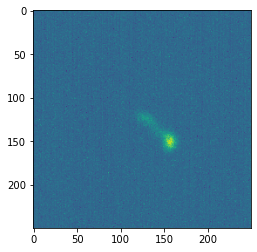

In [99]:
plt.imshow(df_test[(df_test.t==1)].iloc[1].img_250)

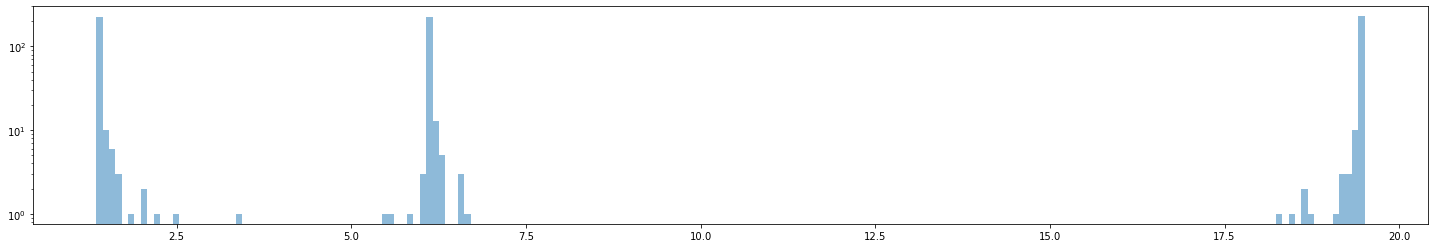

In [100]:
plt.rcParams["figure.figsize"] = (25, 4)
plt.hist(df_test[(df_test.t==0)]['energies_predict_t1'], bins=200, alpha=0.5, log=True)
plt.show()

In [101]:
submission = get_private_test_data()
submission

,file_names,id,classification_predictions,regression_predictions
0,00013a94f1fae3e5a33f8b44c2842c85f0483e96.png,00013a94f1fae3e5a33f8b44c2842c85f0483e96,1,1
1,0005564c011259402dcb6e3beb6e64d285124fa0.png,0005564c011259402dcb6e3beb6e64d285124fa0,1,1
2,0007520c8d8efade8feaafbf74fc7d206cdf229d.png,0007520c8d8efade8feaafbf74fc7d206cdf229d,1,1
3,000804a189f630cd980ff1543c0ef99d48cd6b34.png,000804a189f630cd980ff1543c0ef99d48cd6b34,1,1
4,000eb12def5371089743dcfe401a8e399f5883fc.png,000eb12def5371089743dcfe401a8e399f5883fc,1,1
...,...,...,...,...
15053,ffe6d929d9537cf9b718711a63e41a1b57b509c2.png,ffe6d929d9537cf9b718711a63e41a1b57b509c2,1,1
15054,ffea775cbac98273943841d63b08377d29f08bc7.png,ffea775cbac98273943841d63b08377d29f08bc7,1,1
15055,ffece3dcdcbe2d3125dbed1b8c77f2d6b4832580.png,ffece3dcdcbe2d3125dbed1b8c77f2d6b4832580,1,1
15056,ffed718417c6923844d33e70491c54396e3ec1ed.png,ffed718417c6923844d33e70491c54396e3ec1ed,1,1


In [102]:
submission = pd.concat([submission, df_test])#pd.merge(submission, df_test, how="outer", on=['id'])
submission = submission.fillna(1, axis=0)

In [103]:
submission = submission[['id', 't', 'e']]
submission.t = submission.t.astype(int)
submission.e = submission.e.astype(int)
submission = submission.rename(columns={"t": "classification_predictions", "e": "regression_predictions"})

In [104]:
submission.to_csv('submission.csv', index=False)

In [89]:
submission

,id,classification_predictions,regression_predictions
0,00013a94f1fae3e5a33f8b44c2842c85f0483e96,1,1
1,0005564c011259402dcb6e3beb6e64d285124fa0,1,1
2,0007520c8d8efade8feaafbf74fc7d206cdf229d,1,1
3,000804a189f630cd980ff1543c0ef99d48cd6b34,1,1
4,000eb12def5371089743dcfe401a8e399f5883fc,1,1
...,...,...,...
1497,ff343a62752061d995f94ebc10ac53f79d1b5ab1,1,3
1498,ff897755cb312cd6f510ba7a38cb293e648d97d5,1,3
1499,ff9a93402457ac514cd069a7ce3f2e32692f5290,0,20
1500,ffedc12ec5c142dae2086408b778cf0db2ff944e,1,3


In [ ]:
t = np.random.choice([0, 1], (250*6))
roc_auc_score(t, np.ones((250*6)))*1000

In [449]:
s = 0
for i in range(1000):
    s += mean_absolute_error(np.random.choice([1, 3, 6, 10, 20 ,30], (250*6)), np.ones((250*6))) * 1000
s/1000

10646.29533333333